In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
import numpy as np
import gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

In [2]:
# Charger le DataFrame nettoyé
df = pd.read_csv('stackoverflow_questions_cleaned.csv')

tfidf_max_features = 500
n_topics = 10  # Nombre de sujets

In [3]:
# Fonction pour entraîner, évaluer et logguer le modèle LDA
def train_and_log_lda(column_name):
    print(f"Training LDA model for column: {column_name}")

    # Vectorisation TF-IDF
    tfidf_vectorizer = TfidfVectorizer(max_features=tfidf_max_features)
    X_tfidf = tfidf_vectorizer.fit_transform(df[column_name])

    # Appliquer LDA
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    X_lda = lda.fit_transform(X_tfidf)

    # Calculer la perplexité
    perplexity = lda.perplexity(X_tfidf)
    print(f"Perplexité: {perplexity}")

    # Calculer le score de cohérence
    # Préparation des données pour gensim
    tfidf_data = [doc.split() for doc in df[column_name]]
    dictionary = Dictionary(tfidf_data)
    corpus = [dictionary.doc2bow(text) for text in tfidf_data]
    lda_gensim = gensim.models.LdaModel(corpus, num_topics=n_topics, id2word=dictionary, passes=10)
    coherence_model_lda = CoherenceModel(model=lda_gensim, texts=tfidf_data, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    print(f"Score de cohérence: {coherence_score}")

    # Appliquer t-SNE
    tsne_model = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
    X_tsne = tsne_model.fit_transform(X_lda)

    # Calculer le score de silhouette
    silhouette_avg = silhouette_score(X_tsne, np.argmax(X_lda, axis=1))
    print(f"Score de silhouette: {silhouette_avg}")

    # Visualisation des résultats t-SNE
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=np.argmax(X_lda, axis=1), palette=sns.color_palette("hsv", n_topics), legend="full")
    plt.title(f"t-SNE visualization of LDA topics for {column_name}")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.legend(title="Topics")
    plt.show()

    # Sauvegarder le modèle et la vectorisation
    mlflow.set_experiment("LDA Experiment with t-SNE Visualization")

    with mlflow.start_run(run_name=f"LDA_model_with_tSNE_{column_name}") as run:
        mlflow.log_param("n_topics", n_topics)
        mlflow.log_param("tfidf_max_features", tfidf_max_features)
        mlflow.log_param("column", column_name)
        
        # Loguer les métriques
        mlflow.log_metric("perplexity", perplexity)
        mlflow.log_metric("coherence_score", coherence_score)
        mlflow.log_metric("silhouette_score", silhouette_avg)
        
        # Logger le modèle et les métriques sur MLflow
        mlflow.sklearn.log_model(lda, "LDA_model")
        mlflow.sklearn.log_model(tfidf_vectorizer, "tfidf_vectorizer")
    
    print(f"LDA model training, t-SNE visualization, and logging completed for column: {column_name}")
    print('-------------------------------------------------------------')

Training LDA model for column: title
Perplexité: 921.7405191608245
Score de cohérence: 0.3830789867505191


/Users/anthonydavid/Documents/Etudes/alternance_ML_engineer/OpenClassrooms/projets/projet_5/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Score de silhouette: 0.10353002697229385


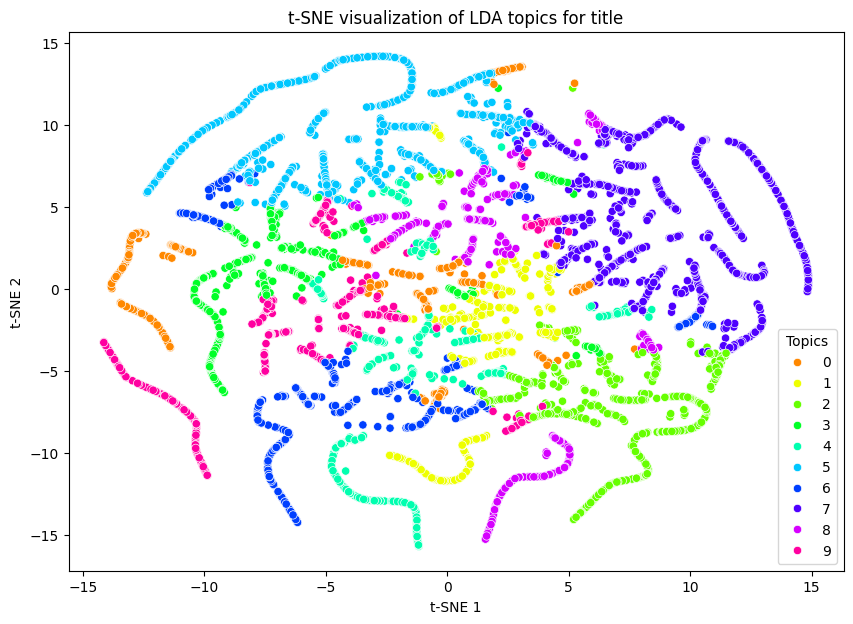

2024/07/17 16:29:33 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/07/17 16:29:35 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


LDA model training, t-SNE visualization, and logging completed for column: title
-------------------------------------------------------------
Training LDA model for column: sentence_bow
Perplexité: 1198.158111822018
Score de cohérence: 0.49223764021992


/Users/anthonydavid/Documents/Etudes/alternance_ML_engineer/OpenClassrooms/projets/projet_5/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Score de silhouette: 0.03986333683133125


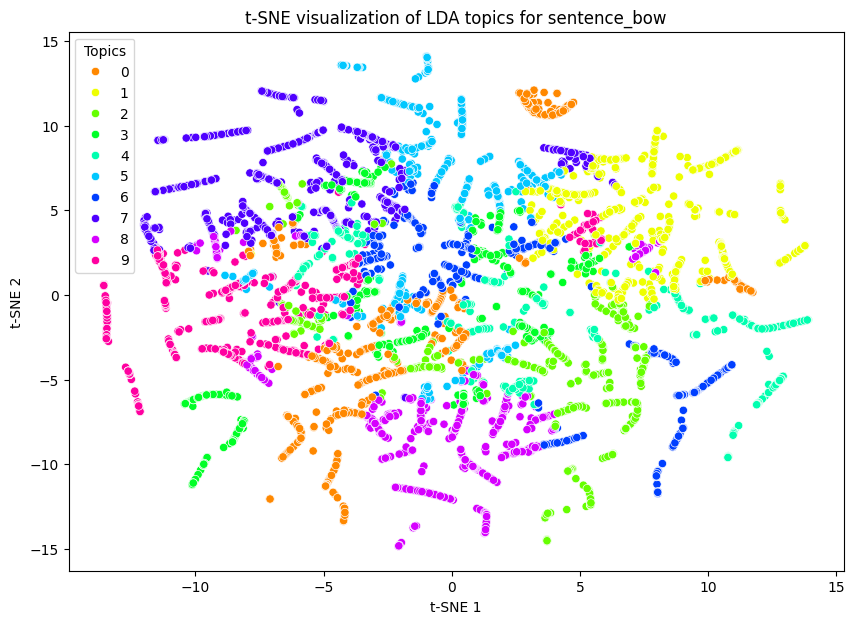

2024/07/17 16:30:15 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/07/17 16:30:18 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


LDA model training, t-SNE visualization, and logging completed for column: sentence_bow
-------------------------------------------------------------
Training LDA model for column: sentence_bow_lem
Perplexité: 1169.0166907958182
Score de cohérence: 0.44537191687230865


/Users/anthonydavid/Documents/Etudes/alternance_ML_engineer/OpenClassrooms/projets/projet_5/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Score de silhouette: 0.07106176018714905


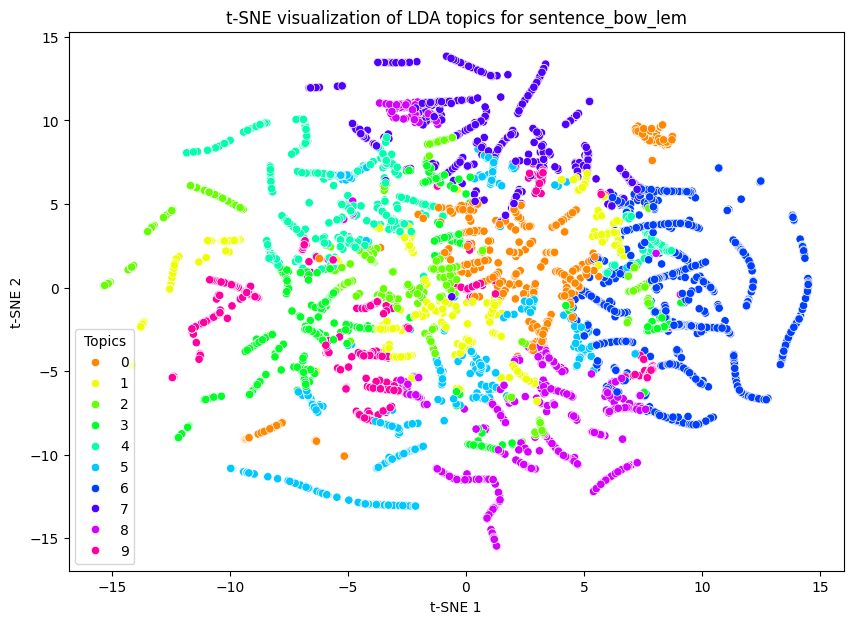

2024/07/17 16:31:05 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/07/17 16:31:07 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


LDA model training, t-SNE visualization, and logging completed for column: sentence_bow_lem
-------------------------------------------------------------


In [17]:
# Entraîner et logguer les modèles pour chaque colonne
columns_to_train = ['title', 'sentence_bow', 'sentence_bow_lem']

for column in columns_to_train:
    train_and_log_lda(column)

In [4]:
# Charger le DataFrame nettoyé
df = pd.read_csv('stackoverflow_questions_cleaned.csv')

tfidf_max_features = 500
n_topics = 20  # Nombre de sujets

In [5]:
# Fonction pour entraîner, évaluer et logguer le modèle LDA
def train_and_log_lda(column_name):
    print(f"Training LDA model for column: {column_name}")

    # Vectorisation TF-IDF
    tfidf_vectorizer = TfidfVectorizer(max_features=tfidf_max_features)
    X_tfidf = tfidf_vectorizer.fit_transform(df[column_name])

    # Appliquer LDA
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    X_lda = lda.fit_transform(X_tfidf)

    # Calculer la perplexité
    perplexity = lda.perplexity(X_tfidf)
    print(f"Perplexité: {perplexity}")

    # Calculer le score de cohérence
    # Préparation des données pour gensim
    tfidf_data = [doc.split() for doc in df[column_name]]
    dictionary = Dictionary(tfidf_data)
    corpus = [dictionary.doc2bow(text) for text in tfidf_data]
    lda_gensim = gensim.models.LdaModel(corpus, num_topics=n_topics, id2word=dictionary, passes=10)
    coherence_model_lda = CoherenceModel(model=lda_gensim, texts=tfidf_data, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    print(f"Score de cohérence: {coherence_score}")

    # Appliquer t-SNE
    tsne_model = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
    X_tsne = tsne_model.fit_transform(X_lda)

    # Calculer le score de silhouette
    silhouette_avg = silhouette_score(X_tsne, np.argmax(X_lda, axis=1))
    print(f"Score de silhouette: {silhouette_avg}")

    # Visualisation des résultats t-SNE
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=np.argmax(X_lda, axis=1), palette=sns.color_palette("hsv", n_topics), legend="full")
    plt.title(f"t-SNE visualization of LDA topics for {column_name}")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.legend(title="Topics")
    plt.show()

    # Sauvegarder le modèle et la vectorisation
    mlflow.set_experiment("LDA Experiment with t-SNE Visualization")

    with mlflow.start_run(run_name=f"LDA_model_with_tSNE_{column_name}") as run:
        mlflow.log_param("n_topics", n_topics)
        mlflow.log_param("tfidf_max_features", tfidf_max_features)
        mlflow.log_param("column", column_name)
        
        # Loguer les métriques
        mlflow.log_metric("perplexity", perplexity)
        mlflow.log_metric("coherence_score", coherence_score)
        mlflow.log_metric("silhouette_score", silhouette_avg)
        
        # Logger le modèle et les métriques sur MLflow
        mlflow.sklearn.log_model(lda, "LDA_model")
        mlflow.sklearn.log_model(tfidf_vectorizer, "tfidf_vectorizer")
    
    print(f"LDA model training, t-SNE visualization, and logging completed for column: {column_name}")
    print('-------------------------------------------------------------')

Training LDA model for column: title
Perplexité: 1508.3002644441044
Score de cohérence: 0.4572850743404494


/Users/anthonydavid/Documents/Etudes/alternance_ML_engineer/OpenClassrooms/projets/projet_5/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Score de silhouette: 0.07885890454053879


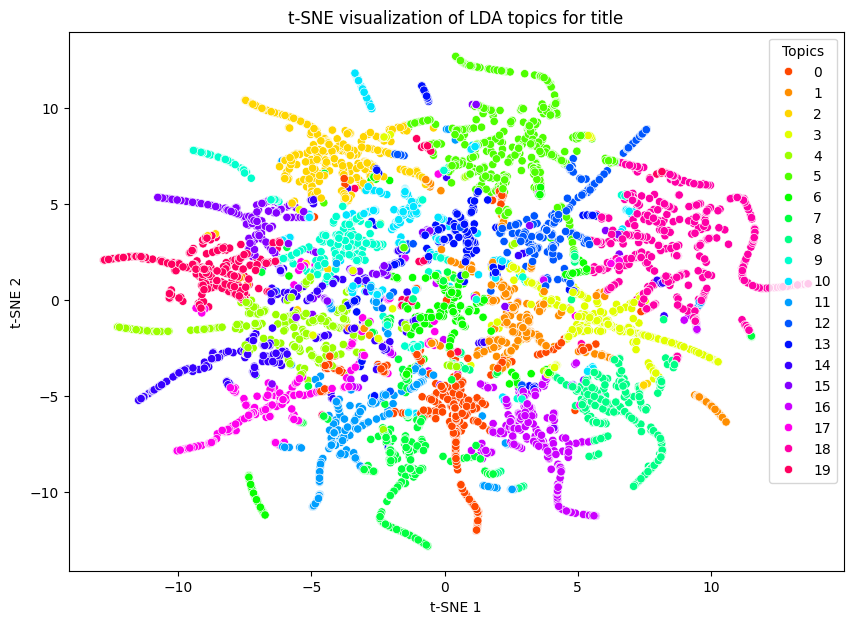

2024/07/19 10:28:00 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/07/19 10:28:04 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


LDA model training, t-SNE visualization, and logging completed for column: title
-------------------------------------------------------------
Training LDA model for column: sentence_bow
Perplexité: 1943.616993454221
Score de cohérence: 0.5236496938413607


/Users/anthonydavid/Documents/Etudes/alternance_ML_engineer/OpenClassrooms/projets/projet_5/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Score de silhouette: -0.045815616846084595


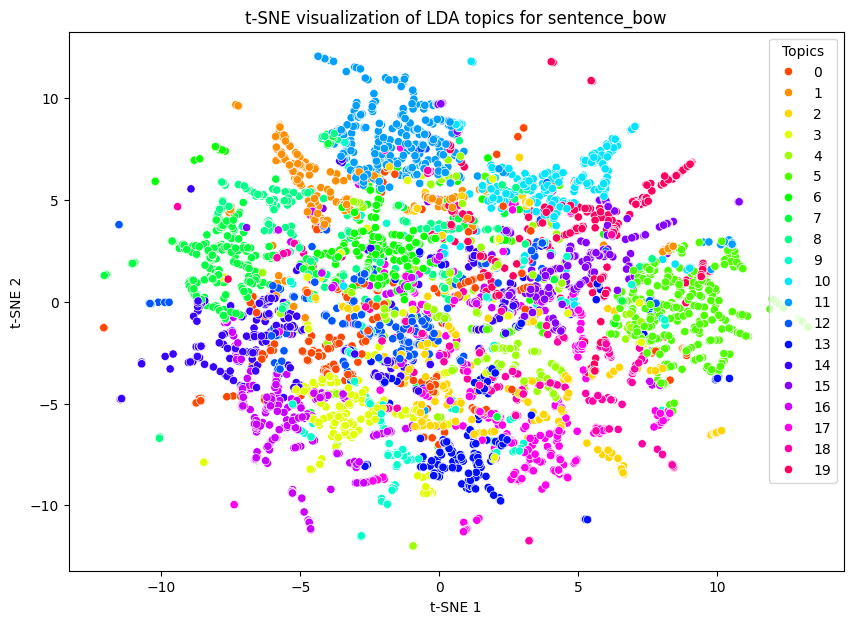

2024/07/19 10:28:55 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/07/19 10:28:58 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


LDA model training, t-SNE visualization, and logging completed for column: sentence_bow
-------------------------------------------------------------
Training LDA model for column: sentence_bow_lem
Perplexité: 1946.0138981069892
Score de cohérence: 0.49467998224494397


/Users/anthonydavid/Documents/Etudes/alternance_ML_engineer/OpenClassrooms/projets/projet_5/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Score de silhouette: -0.012672331184148788


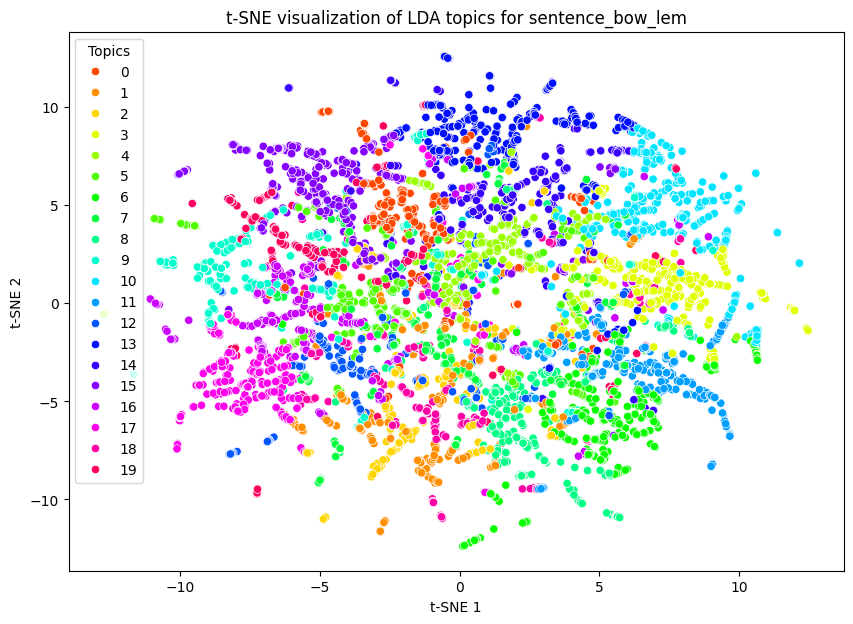

2024/07/19 10:29:51 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/07/19 10:29:53 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


LDA model training, t-SNE visualization, and logging completed for column: sentence_bow_lem
-------------------------------------------------------------


In [6]:
# Entraîner et logguer les modèles pour chaque colonne
columns_to_train = ['title', 'sentence_bow', 'sentence_bow_lem']

for column in columns_to_train:
    train_and_log_lda(column)